# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

Import libraries

In [5]:
import numpy as np
import pandas as pd
import scipy as sp

from IPython.display import Image
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier as BaseLine
from sklearn.decomposition import PCA
from sklearn.utils import resample

import StringIO
import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

**---**

## Open a dataset



In [6]:
# Open data set as a sample:
# --------------------------

# Data dictionary
data_dic = {}

# specify date columns
date_range = [[0,1,2,3,4]]

# Open the data files
for i in range(8):
    file_name = 'datasets/data_' + str(i+1) + '.txt'
    inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                              parse_dates = date_range , infer_datetime_format = True)
    data_dic['df_' + str(i + 1)] = inter.iloc[:,1:]

# Sanity check    
data_dic['df_1'].head(10)

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,75,10.0,11.9,2.63,9.09,6.28,91,1016.8,26.5,27.0,22.5,99.0,99.0
1,78,10.1,12.5,2.59,9.09,6.14,109,1017.2,26.5,27.0,22.4,99.0,99.0
2,85,10.2,11.9,2.71,8.33,6.35,100,1017.1,26.3,27.0,22.5,99.0,99.0
3,84,10.2,13.1,2.88,9.09,6.51,89,1016.6,26.3,27.0,22.4,99.0,99.0
4,80,10.4,12.8,2.83,7.69,6.29,80,1016.1,26.4,27.0,22.3,99.0,99.0
5,78,10.1,12.3,3.11,9.09,6.50,99,1015.7,26.1,26.9,22.3,99.0,99.0
6,76,10.4,12.0,2.87,9.09,6.38,91,1015.0,26.2,26.9,21.9,99.0,99.0
7,80,10.2,11.7,2.91,9.09,6.47,95,1014.6,26.3,26.9,21.5,99.0,99.0
8,78,10.1,11.8,3.12,9.09,6.74,101,1014.7,26.3,27.0,21.5,99.0,99.0
9,74,9.6,11.8,2.83,9.09,6.53,110,1015.1,26.2,27.0,21.3,99.0,99.0


In [7]:
# Concatenate all files:
# ---------------------

# initiation
df_global = data_dic['df_1']

# concatente
for i in range(2,9):
    df_global = pd.concat([df_global , data_dic['df_' + str(i)]] , axis = 0)

# data array
data_raw = df_global.values

In [8]:
# Preprocessing
# -------------

# Exclude tide data
data = data_raw[:, :-2]

# Normalization
data_norm = data / np.std(data, axis = 0)

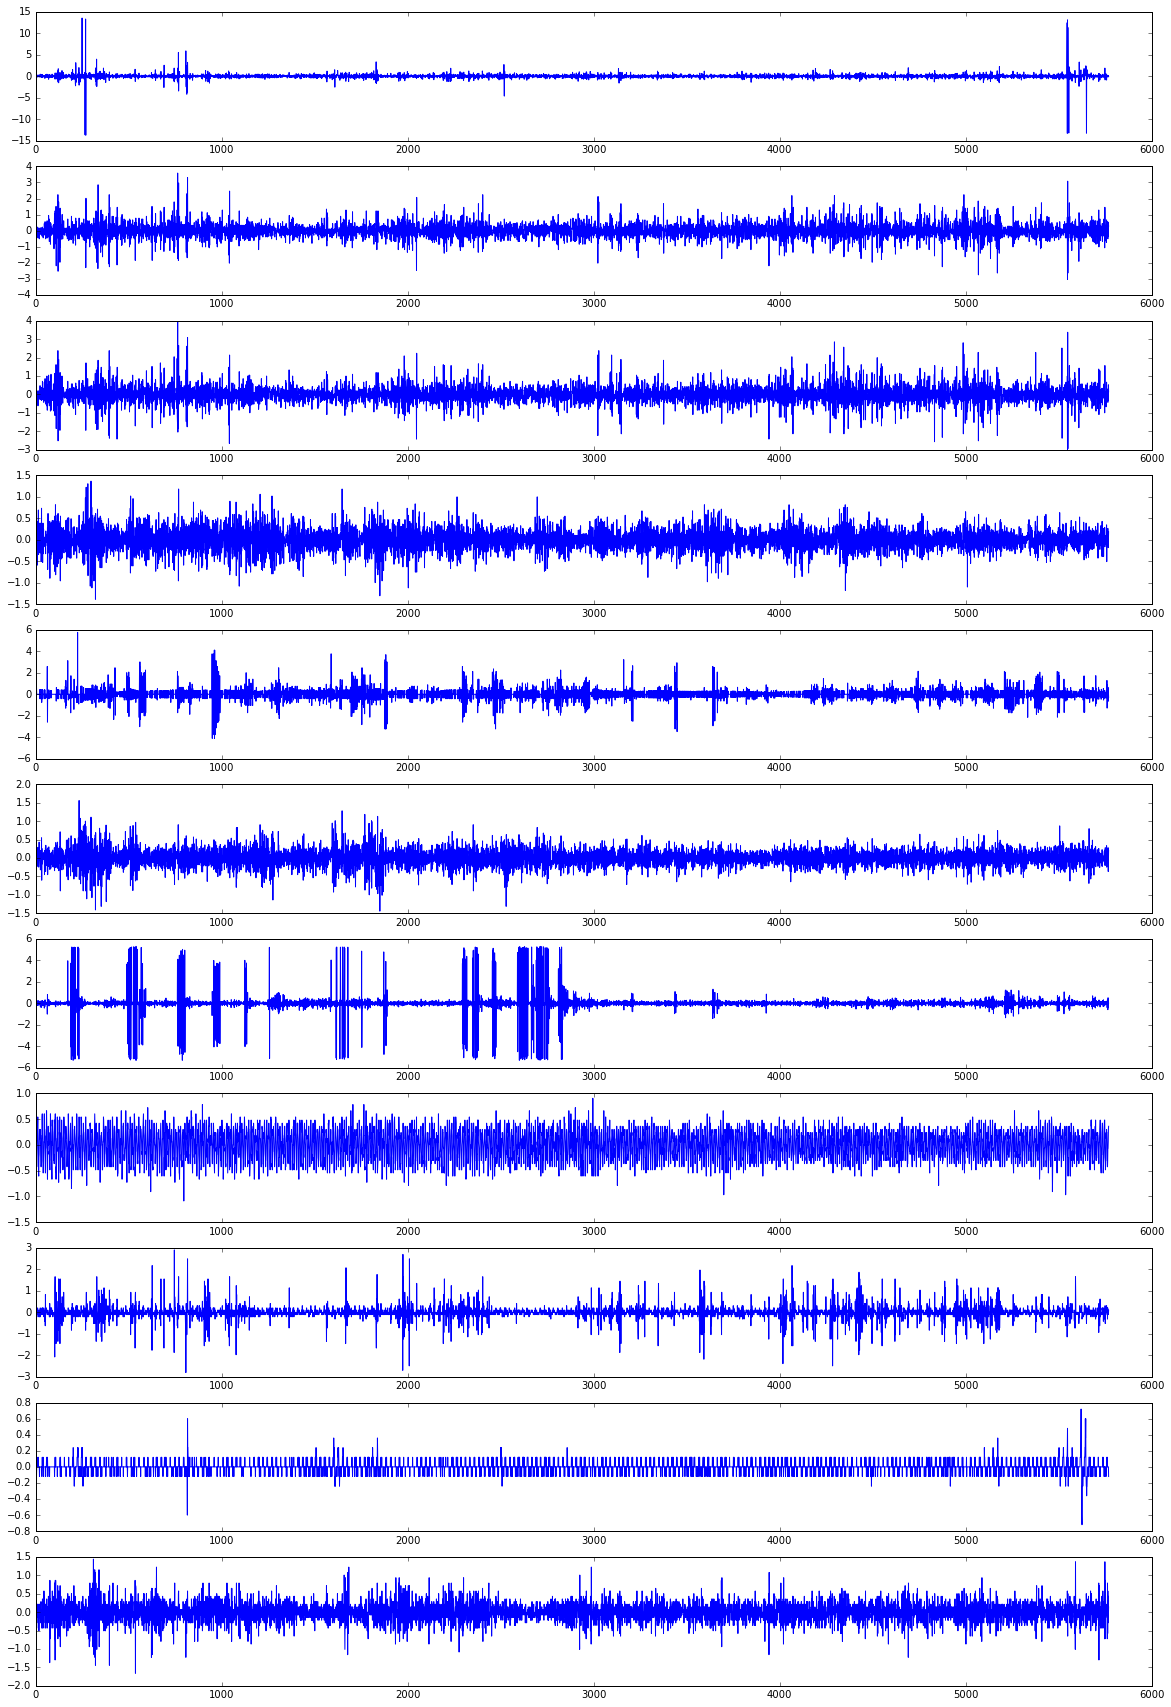

In [9]:
# One-step-difference filter application
# --------------------------------------

data_fil = np.zeros(data_norm.shape)

for i in range (1, data_norm.shape[0]):
    data_fil[i, :] = data_norm[i,:] - data_norm[i-1,:]


# Visualization
fig = plt.figure(figsize = (20, 30))
n = data_fil.shape[1]

# iterrate for data columns
for i in range (n):
    ax = fig.add_subplot(n,1,i + 1)
    ax.plot(data_fil[:,i])
    
plt.show()

In [224]:
# simulated Data
# --------------

d1 = np.random.normal(0. , 0.5 , (3000 , 2))
d2 = np.random.normal(0. , 0.6 , (500 , 2))
d3 = np.random.normal(0. , 0.5 , (3000 , 2))

dat1 = np.concatenate((d1 , d2) , axis = 0)

sim_data = np.concatenate((dat1 , d3), axis = 0)

In [240]:
# Function to calculate Power Martingale:
# ---------------------------------------

def power_martingale(d):

    # epsilon value
    eps = 0.9
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( np.sum(alpha_sub > end) + np.random.uniform() * np.sum(alpha_sub == end ) ) / n
    
        # to avoid log zero
        p_value[p_value==0] = 1.
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # Change det
    det = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for power martingale calculation
    for i in range(L):
        
        # Value holder
        M1 = M
    
        # iterrate for each epsilon    
        M += np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Arrays
        power_mart[i] = M
        
        det[i] = np.exp(M - M1)
        
    return power_mart , det

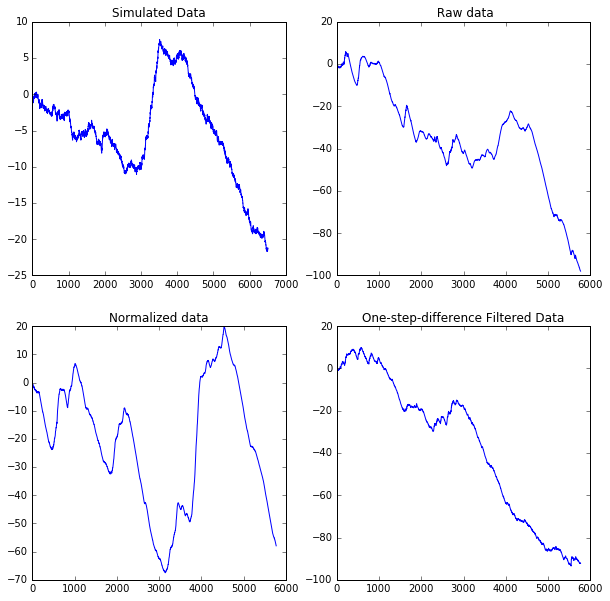

In [241]:
# Application and Visualization
# -----------------------------

# simulated data 
p_mar1 , det1 = power_martingale(sim_data)

# Raw data
p_mar2 , det2 = power_martingale(data)

# normalized data
p_mar3 , det3 = power_martingale(data_norm)

# on-step-difference filtered data
p_mar4 , det4 = power_martingale(data_fil)

# plot initialization
fig = plt.figure(figsize = (10,10))

# plot simulated data
ax1 = fig.add_subplot(221)
ax1.plot(p_mar1)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(222)
ax2.plot(p_mar2)
ax2.set_title(' Raw data')

# plot normalized data
ax3 = fig.add_subplot(223)
ax3.plot(p_mar3)
ax3.set_title('Normalized data')

# plot one-step-difference filtered data
ax4 = fig.add_subplot(224)
ax4.plot(p_mar4)
ax4.set_title('One-step-difference Filtered Data')

plt.show()

In [242]:
# Kalman Filter
# ------------

def kalman(y):
    x = np.zeros(y.shape)
    p = np.zeros(y.shape)
    q = 0.001
    r = 10.
    L = y.shape[0]
    x[0] = y[0]
    p[0] = 0.1
    for i in range(1,L):
        p[i] = p[i - 1] + q
        k = p[i] / (p[i] + r)
        x[i] = x[i - 1] + k * (y[i] - x[i - 1])
        p[i] = p[i] * ( 1 - k )
        
    return x

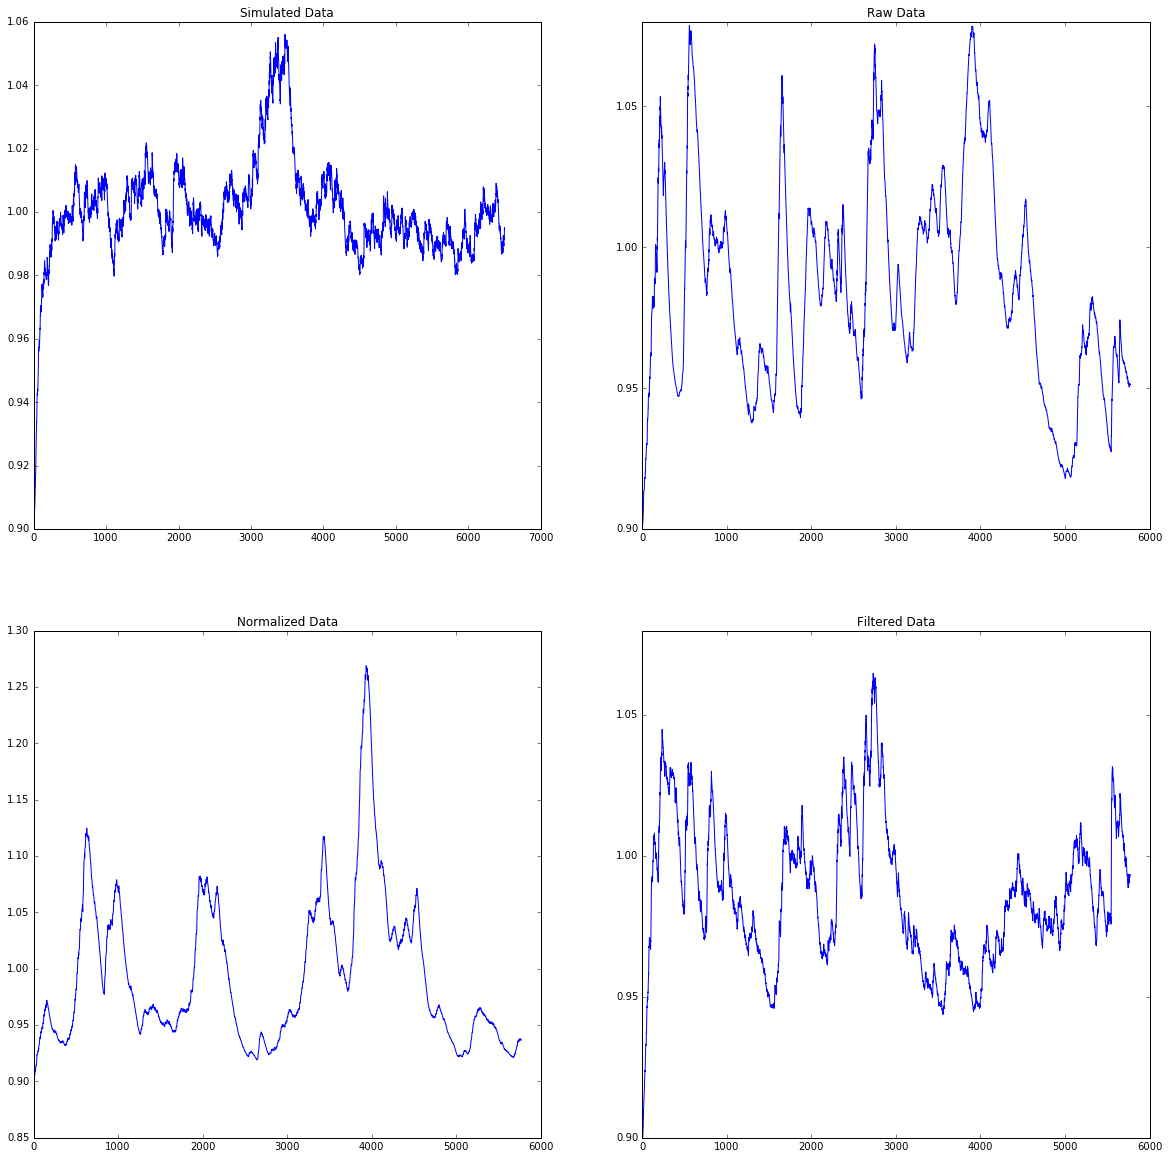

In [243]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,20))

# determine length
L = det1.shape[0]

# specify start and end
a , b = 0 , L

# Simulated Data
ax1 = fig.add_subplot(221)
ax1.plot(kalman(det1[a:b]))
ax1.set_title('Simulated Data')

# Raw data
ax2 = fig.add_subplot(222)
ax2.plot(kalman(det2[a:b]) )
ax2.set_title('Raw Data')

# Normalized data
ax3 = fig.add_subplot(223)
ax3.plot(kalman(det3[a:b]) )
ax3.set_title('Normalized Data')

# Normalized data
ax4 = fig.add_subplot(224)
ax4.plot(kalman(det4[a:b]))
ax4.set_title('Filtered Data')

plt.show()